In [192]:
import ee
import geemap
import os
import numpy as np
from scipy import signal as sp
from matplotlib import pyplot as plt

In [193]:
Map = geemap.Map(center = (-2.609097222, -60.20929722), zoom = 8)
Map

Map(center=[-2.609097222, -60.20929722], controls=(WidgetControl(options=['position'], widget=HBox(children=(T…

In [208]:
#Load manause Venus footprint
manaus_shp = '/Users/morgansteckler/Downloads/venus_fgmanaus_footprint/venus_fgmanaus_footprint.shp'
manaus = geemap.shp_to_ee(manaus_shp)

In [194]:
#Load corumba Venus footprint
corumba_shp = '/Users/morgansteckler/Downloads/venus_corumba_footprint/venus_corumba_footprint.shp'
corumba = geemap.shp_to_ee(corumba_shp)

In [219]:
atto_shp = '/Users/morgansteckler/Downloads/venus_atto_footprint/venus_atto_footprint.shp'
atto = geemap.shp_to_ee(atto_shp)

In [231]:
mato_shp = '/Users/morgansteckler/Downloads/venus_mato_footprint/venus_mato_footprint.shp'
mato = geemap.shp_to_ee(mato_shp)

In [242]:
saop_shp = '/Users/morgansteckler/Downloads/venus_saop_footprint/venus_saop_footprint.shp'
saop = geemap.shp_to_ee(saop_shp)

In [243]:
#Set choice footprint
json = saop

In [244]:
#Grab 2015 discrete landcover classes at 100 m resoltion
lc = (ee.Image("COPERNICUS/Landcover/100m/Proba-V/Global/2015")
      .select('discrete_classification')
      .clip(json))
#Set palette for visualization
lc_params = {'palette':
             ['282828', 'FFBB22', 'FFFF4C', 'F096FF', 
              'FA0000', 'B4B4B4', 'F0F0F0', '0032C8', 
              '0096A0', 'FAE6A0', '58481F', '009900', 
              '70663E', '00CC00', '4E751F', '007800', 
              '666000', '8DB400', '8D7400', 'A0DC00', 
              '929900', '648C00', '000080']}

In [222]:
Map.addLayer(lc, lc_params, 'corumba')

In [245]:
#Calculate pixel area for each pixel in an image
def pixelArea(img):
    area = ee.Image.pixelArea()
    return img.addBands(area)

In [246]:
#Create an area image and combine with landcover classes
area_img = pixelArea(lc);
area_img = area_img.select('area')
both = area_img.addBands(lc)

In [247]:
#Calculate total area per landcover class
def pixelSum(img):
    reducer = (ee.Reducer
               .sum()
               .group(groupField= 1, groupName= 'class'))
    return img.reduceRegion(reducer=reducer, geometry=json, scale=100, maxPixels=1e8)

#Create dictionary as {'groups': [{'class':#, 'sum':#}, etc]} and print
dictionary = pixelSum(both)
area_sums = dictionary.getInfo()
print(area_sums)

{'groups': [{'class': 20, 'sum': 16543012.944722734}, {'class': 30, 'sum': 281735015.2002375}, {'class': 40, 'sum': 396756693.7725992}, {'class': 50, 'sum': 6822790.371300551}, {'class': 60, 'sum': 164720.884765625}, {'class': 80, 'sum': 12466207.454484522}, {'class': 90, 'sum': 3467496.3362362133}, {'class': 112, 'sum': 566527914.3084749}, {'class': 114, 'sum': 10469800.103910077}, {'class': 116, 'sum': 128685260.12310816}, {'class': 122, 'sum': 23695088.42065334}, {'class': 124, 'sum': 606151.7892769608}, {'class': 126, 'sum': 282114830.179163}]}


In [248]:
#Grab the list of dicitonaries
sums = list(area_sums['groups'])
print(sums)

[{'class': 20, 'sum': 16543012.944722734}, {'class': 30, 'sum': 281735015.2002375}, {'class': 40, 'sum': 396756693.7725992}, {'class': 50, 'sum': 6822790.371300551}, {'class': 60, 'sum': 164720.884765625}, {'class': 80, 'sum': 12466207.454484522}, {'class': 90, 'sum': 3467496.3362362133}, {'class': 112, 'sum': 566527914.3084749}, {'class': 114, 'sum': 10469800.103910077}, {'class': 116, 'sum': 128685260.12310816}, {'class': 122, 'sum': 23695088.42065334}, {'class': 124, 'sum': 606151.7892769608}, {'class': 126, 'sum': 282114830.179163}]


In [249]:
#Create a new list with just the values and print
def valuesList(alist):
    values = []
    for value in alist:
        values.append(value['sum'])
    return values

values_list = valuesList(sums)
print(values_list)

def keysList(alist):
    keys = []
    for key in alist:
        keys.append(key['class'])
    return keys

keys_list = keysList(sums)
print(keys_list)

[16543012.944722734, 281735015.2002375, 396756693.7725992, 6822790.371300551, 164720.884765625, 12466207.454484522, 3467496.3362362133, 566527914.3084749, 10469800.103910077, 128685260.12310816, 23695088.42065334, 606151.7892769608, 282114830.179163]
[20, 30, 40, 50, 60, 80, 90, 112, 114, 116, 122, 124, 126]


In [250]:
#Calculate total area by summing all the sums
total_area = sum(map(float, values_list))
print(total_area)

1730054981.888933


In [251]:
#Create list of percent area per class and print
def percentArea(alist):
    percents = []
    for value in alist:
        percent = (value / total_area)*100
        percents.append(percent)
    return percents

area_percents = percentArea(values_list)
print(area_percents)

[0.9562131329872828, 16.28474344165812, 22.933184085248364, 0.3943684127224209, 0.009521135830364022, 0.7205671256108573, 0.20042694437666267, 32.74623756118551, 0.6051715242297556, 7.438217945108612, 1.3696147618835925, 0.03503656216839673, 16.306697366990058]


In [252]:
class_percents = list(zip(keys_list, area_percents))
print(class_percents)

[(20, 0.9562131329872828), (30, 16.28474344165812), (40, 22.933184085248364), (50, 0.3943684127224209), (60, 0.009521135830364022), (80, 0.7205671256108573), (90, 0.20042694437666267), (112, 32.74623756118551), (114, 0.6051715242297556), (116, 7.438217945108612), (122, 1.3696147618835925), (124, 0.03503656216839673), (126, 16.306697366990058)]


In [295]:
corumba_list = [(20, 12.882118384212607), (30, 24.998429848191886), (40, 23.705948144675805), (50, 0.284567771126083), (60, 0.008720130789419946), (80, 5.631341623091446), (90, 1.5813137388503122), (112, 2.8582962792901343), (114, 0.8714794256041105), (116, 8.01201487749318), (122, 0.04532739922923814), (124, 0.09590702524695108), (126, 19.024535352198814)]

In [296]:
manaus_list = [(20, 0.000918746104623805), (30, 0.1322253840144901), (40, 0.0009186773060563634), (50, 0), (60,0), (80,0), (90,0), (112, 99.37287780284623), (114,0), (116, 0.11632269758649091), (122, 0.27126705058785705), (124,0), (126, 0.1054696415542391)]

In [297]:
atto_list = [(20, 0.02729921500341903), (30, 0.2615468007245986), (40,0), (50,0), (60,0),(80, 1.8279081508069446), (90, 2.0984705453076864), (112, 94.52921547918731), (114,0), (116, 1.1745427084572961), (122, 0.0026418402255512148), (124,0), (126, 0.07837526028719781)]

In [298]:
mato_list = [(20, 15.497364662478539), (30, 28.665491236672718), (40, 11.64874403705068), (50, 0.18499624339654286), (60, 0.07598692345273453), (80, 1.7174056855540756), (90, 0.42575453247721334), (112, 5.947169993916441), (114, 4.538274888419497), (116, 17.479305977356894), (122, 0.011902671026909097), (124, 0.006407953770433252), (126, 13.801195194427315)]

In [299]:
saop_list = [(20, 0.9562131329872828), (30, 16.28474344165812), (40, 22.933184085248364), (50, 0.3943684127224209), (60, 0.009521135830364022), (80, 0.7205671256108573), (90, 0.20042694437666267), (112, 32.74623756118551), (114, 0.6051715242297556), (116, 7.438217945108612), (122, 1.3696147618835925), (124, 0.03503656216839673), (126, 16.306697366990058)]

In [300]:
corumba_labels = [i[0] for i in corumba_list]
manaus_labels = [i[0] for i in manaus_list]
atto_labels = [i[0] for i in atto_list] 
mato_labels = [i[0] for i in mato_list]
saop_labels = [i[0] for i in saop_list]

In [301]:
corumba_values = [i[1] for i in corumba_list]
manaus_values = [i[1] for i in manaus_list]
atto_values = [i[1] for i in atto_list]
mato_values = [i[1] for i in mato_list]
saop_values = [i[1] for i in saop_list]

In [306]:
def Union(lst1, lst2, lst3, lst4, lst5): 
    final_list = list(set().union(lst1, lst2, lst3, lst4, lst5)) 
    return sorted(final_list)

labels = Union(corumba_labels, manaus_labels, atto_labels, mato_labels, saop_labels)

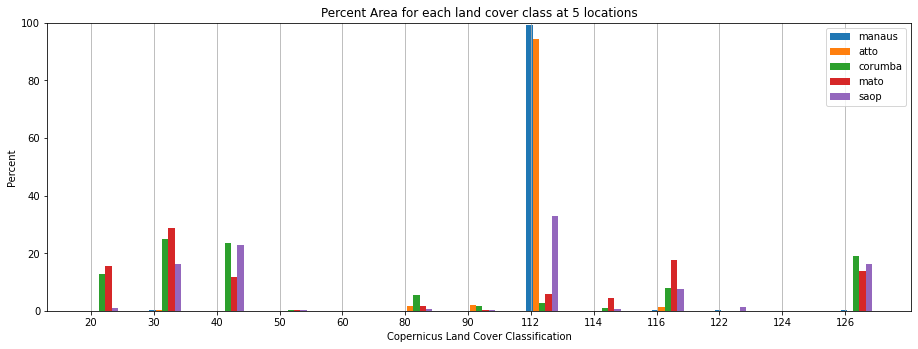

In [373]:
#5 locations zoomed out
#Set values
x = np.arange(len(labels))
bar_width = 0.1
plt.axes([2, 0, 2, 1])

#Create
plt.ylim(bottom = 0, top = 100)
plt.bar(x, height=manaus_values, width=bar_width, label="manaus")
plt.bar(x + bar_width, height=atto_values, width=bar_width, label="atto")
plt.bar(x + bar_width*2, height=corumba_values, width=bar_width, label="corumba")
plt.bar(x + bar_width*3, height=mato_values, width=bar_width, label="mato")
plt.bar(x + bar_width*4, height=saop_values, width=bar_width, label="saop")

#Format
plt.title("Percent Area for each land cover class at 5 locations")
plt.ylabel("Percent")
plt.xlabel("Copernicus Land Cover Classification")
plt.xticks(x + bar_width / 5, labels = labels)
plt.grid(b = True, which = 'major', axis = 'x')
plt.legend(loc = "upper right")
plt.show()

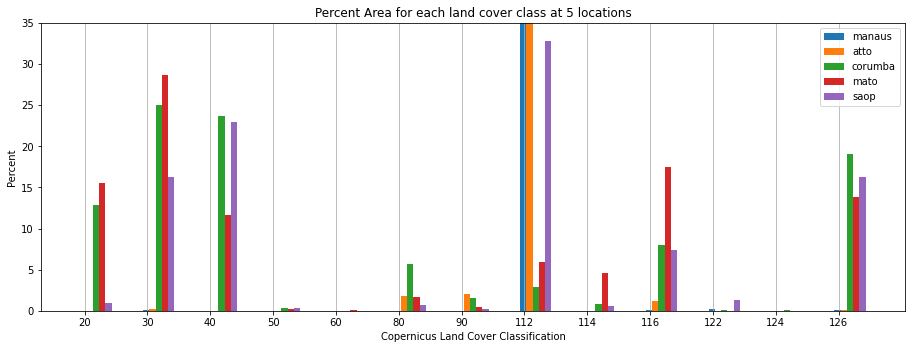

In [375]:
#Zoomed in
x = np.arange(len(labels))
bar_width = 0.1
plt.axes([2, 0, 2, 1])

#Create
plt.ylim(bottom = 0, top = 35)
plt.bar(x, height=manaus_values, width=bar_width, label="manaus")
plt.bar(x + bar_width, height=atto_values, width=bar_width, label="atto")
plt.bar(x + bar_width*2, height=corumba_values, width=bar_width, label="corumba")
plt.bar(x + bar_width*3, height=mato_values, width=bar_width, label="mato")
plt.bar(x + bar_width*4, height=saop_values, width=bar_width, label="saop")

#Format
plt.title("Percent Area for each land cover class at 5 locations")
plt.ylabel("Percent")
plt.xlabel("Copernicus Land Cover Classification")
plt.xticks(x + bar_width / 5, labels = labels)
plt.grid(b = True, which = 'major', axis = 'x')
plt.legend(loc = "upper right")
plt.show()